In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import torch
import math
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# device = torch.device('cpu')
gpu = 5
device = torch.device(f"cuda:{gpu}" if gpu != -1 else "cpu")
from src.metrics import *

import seaborn as sns

In [27]:
def get_rmse(y, yhat):
    if y.device != "cpu":
        y = y.detach().cpu()
    if not isinstance(y, np.ndarray):
        y = y.numpy()
    assert y.shape == yhat.shape
    return np.sqrt(np.mean((y-yhat)**2))

def get_particle_prediction(samples, X):

    if not isinstance(X, np.ndarray):
        if X.device != "cpu":
            X = X.detach().cpu()
        X = X.numpy()
    if not isinstance(samples, np.ndarray):
        if samples.device != "cpu":
            samples = samples.detach().cpu()
        samples = samples.numpy()
    pred = (np.mean(samples, axis=0) @ X.T).T[:, None]
    assert pred.shape == (X.shape[0], 1), f"pred is shape {pred.shape}"
    return pred
def plot_histogram(samples, label="SVGD"):
    if not isinstance(samples, np.ndarray):
        if samples.device != "cpu":
            samples = samples.detach().cpu()
        samples = samples.numpy()
    sns.kdeplot(samples, label=label)

In [4]:
class BayesianLinearRegression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = self.X.shape[0]
        self.p = self.X.shape[1]

    def log_prob(self, samples: np.ndarray):
        """Parts from https://pytorch.org/docs/stable/_modules/torch/distributions/normal.html#Normal.log_prob

        w: num_particles x p

        num_particles x n
        y: n x 1

        """
        w = samples[:,:-1]
        sigma = samples[:,-1:]
        # mean: (num_particles x d) x (d x num_data) -> (num_data x num_particles)
        mean = (w @ self.X.T).T
        return -0.01*sigma - self.n*sigma.log() - torch.sum((self.y - mean)**2, axis=0)[:, None] / (2*sigma**2) - torch.sum((w**2) / 2, axis=1)[:, None]


In [5]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
X, y = load_boston(return_X_y=True)
y =  y[:, None]
# X = X[:, [5, 12]]
scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)
X = scaler_X.transform(X)
y = scaler_y.transform(y)
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device)

In [6]:
blr = BayesianLinearRegression(X, y)

In [8]:
blr.log_prob(torch.ones((20, 14), device=device)).shape

torch.Size([20, 1])

## HMC

In [10]:
import pymc3 as pm
import arviz as az
from pymc3 import *

In [11]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [13]:
with Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    w = MvNormal("w", 0, cov=np.eye(X.shape[1]), shape=X.shape[1])
    sigma = Gamma("sigma", 1, 0.01)

    # Define likelihood
    likelihood = Normal("y", mu= (w @ X.detach().cpu().numpy().T).T, sigma=sigma, observed=y.detach().cpu().numpy()[:,0])

    # Inference!
    trace = sample(3000, cores=1, chains=1)  # draw 3000 posterior samples using NUTS sampling

/home/hbz15/M-SVGD/.env/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


-Variables
There are 14 attributes in each case of the dataset. They are:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

5, 12 are the key ones

In [14]:
mcmc_samples = trace.get_values("w")

In [15]:
redundant_cols = [0,1,2,3,4,6,7,8,9,10,11]

In [20]:
print(f"RMSE all cols: {get_rmse(y, get_particle_prediction(mcmc_samples, X))}, RM&LSTAT: {get_rmse(y, get_particle_prediction(mcmc_samples[:, [5, 12]], X[:, [5,12]]))}")
print(f"Without RM&LSTAT: {get_rmse(y, get_particle_prediction(mcmc_samples[:, redundant_cols], X[:, redundant_cols]))}")

RMSE all cols: 0.5092736444504206, RM&LSTAT: 0.6248811995244564
Without RM&LSTAT: 0.8099126612310749


/home/hbz15/M-SVGD/.env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

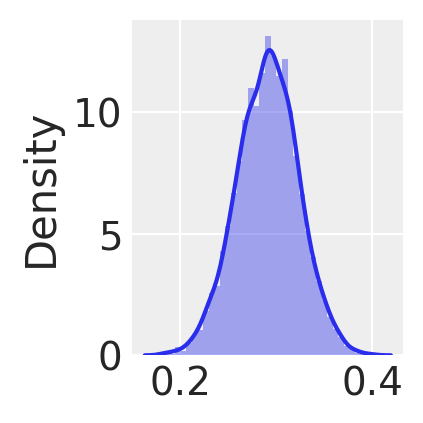

In [21]:
plt.figure(figsize=(2,2))
sns.distplot(mcmc_samples[:,5], hist=True)

## SVGD

In [100]:
from src.svgd import SVGD
from src.kernel import RBF


In [110]:
nparticles = 50
x_svgd = torch.randn((nparticles, X.shape[1]+1), device=device)
optimizer = optim.Adam([x_svgd], lr=0.1)
num_epochs = 10000

svgd = SVGD(blr, kernel=RBF(sigma=1), optimizer=optimizer, device="cpu")
_ = svgd.fit(x_svgd, epochs=num_epochs)

100%|██████████| 10000/10000 [00:58<00:00, 171.74it/s]


In [111]:
print(f"RMSE all cols: {get_rmse(y, get_particle_prediction(x_svgd[:,:-1], X))}, RM&LSTAT: {get_rmse(y, get_particle_prediction(x_svgd[:, [5, 12]], X[:, [5,12]]))}")
print(f"Without RM&LSTAT: {get_rmse(y, get_particle_prediction(x_svgd[:, redundant_cols], X[:, redundant_cols]))}")

RMSE all cols: 0.5097596049308777, RM&LSTAT: 0.6235930323600769
Without RM&LSTAT: 0.8007689118385315


In [112]:
import seaborn as sns

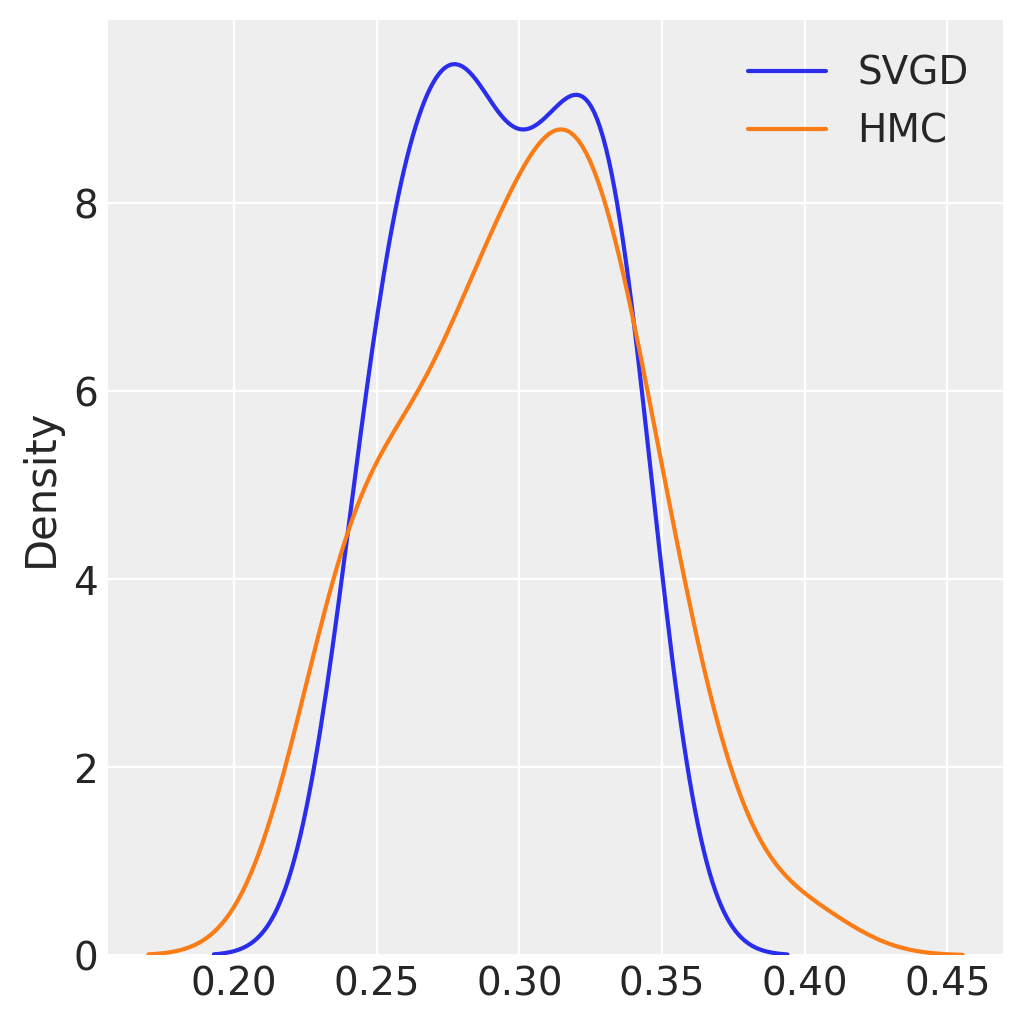

In [113]:
plt.figure(figsize=(5,5))
plot_histogram(x_svgd[:,5], label="SVGD")
sns.kdeplot(mcmc_samples[-50:,5], label="HMC")
plt.legend()

In [128]:
energy_dist(x_svgd[:,[5,12]], torch.Tensor(mcmc_samples[-500:, [5,12]]).to(device))

0.022364486008882523

## Sliced SVGD

In [95]:
from src.maxsvgd import MaxSVGD

In [96]:
nparticles = 50
x_maxsvgd = torch.randn((nparticles, X.shape[1]+1), device=device).requires_grad_()
num_epochs = 10000

maxsvgd = MaxSVGD(blr, device=device)
x_maxsvgd, _ = maxsvgd.fit(x_maxsvgd, n_epoch=num_epochs, lr=0.1, eps=0.01)

100%|██████████| 10000/10000 [02:50<00:00, 58.81it/s]


In [97]:
print(f"RMSE all cols: {get_rmse(y, get_particle_prediction(x_maxsvgd[:,:-1].detach(), X))}, RM&LSTAT: {get_rmse(y, get_particle_prediction(x_maxsvgd[:, [5, 12]].detach(), X[:, [5,12]]))}")
print(f"Without RM&LSTAT: {get_rmse(y, get_particle_prediction(x_maxsvgd[:, redundant_cols].detach(), X[:, redundant_cols]))}")

RMSE all cols: 0.510272204875946, RM&LSTAT: 0.6226781606674194
Without RM&LSTAT: 0.7978063821792603


/home/hbz15/M-SVGD/.env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


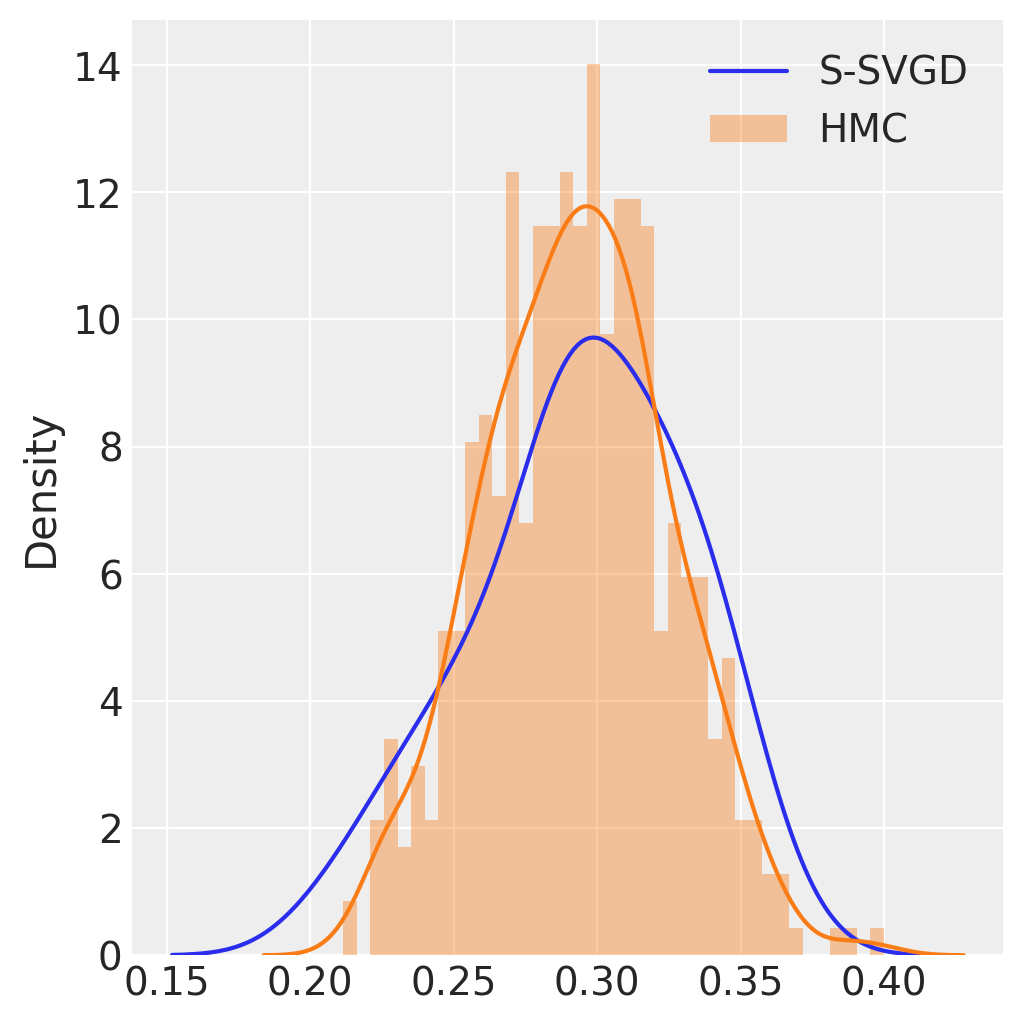

In [98]:
plt.figure(figsize=(5,5))
plot_histogram(x_maxsvgd[:,5], label="S-SVGD")
sns.distplot(mcmc_samples[-500:,5], hist=True, bins=40, label="HMC")
plt.legend()

In [127]:
energy_dist(x_maxsvgd[:,[5,12]], torch.Tensor(mcmc_samples[-50:, [5,12]]).to(device))

0.04219841957092285

## GSVGD

In [106]:
from src.gsvgd import FullGSVGDBatch
from src.manifold import Grassmann
from src.kernel import BatchRBF

In [122]:
eff_dim = 2
D = X.shape[1]+1
nparticles = 50
theta0 = torch.randn((nparticles, X.shape[1]+1), device=device)
lr = 0.1
delta = 0.1
add_noise = True
num_epochs = 10000

print(f"Running GSVGD with eff dim = {eff_dim}")
# m = min(D, 20) // eff_dim
m = min(20, D // eff_dim)
# m = 20
# m = min(100, D // eff_dim)
print("number of projections:", m)

# sample from variational density
x_gsvgd = theta0.clone().requires_grad_()

# kernel_gsvgd = Kernel(method="med_heuristic")
kernel_gsvgd = BatchRBF(sigma=1,method="med_heuristic")
optimizer = optim.Adam([x_gsvgd], lr=lr)
manifold = Grassmann(D, eff_dim)
# U = torch.eye(D).requires_grad_(True).to(device)
# U = U[:, :(m*eff_dim)]
U = torch.nn.init.orthogonal_(
    torch.empty(D, m*eff_dim)
).requires_grad_(True).to(device)

gsvgd = FullGSVGDBatch(
    target=blr,
    kernel=kernel_gsvgd,
    manifold=manifold,
    optimizer=optimizer,
    delta=delta,
    device=device,
    noise=add_noise,
    T=1e-4,
)
U, metric_gsvgd = gsvgd.fit(x_gsvgd, U, m, epochs=num_epochs)


  0%|          | 5/10000 [00:00<03:30, 47.47it/s]

Running GSVGD with eff dim = 2
number of projections: 7


100%|██████████| 10000/10000 [04:39<00:00, 35.76it/s]


In [123]:
print(f"RMSE all cols: {get_rmse(y, get_particle_prediction(x_gsvgd[:,:-1].detach(), X))}, RM&LSTAT: {get_rmse(y, get_particle_prediction(x_gsvgd[:, [5, 12]].detach(), X[:, [5,12]]))}")
print(f"Without RM&LSTAT: {get_rmse(y, get_particle_prediction(x_gsvgd[:, redundant_cols].detach(), X[:, redundant_cols]))}")

RMSE all cols: 0.5092729926109314, RM&LSTAT: 0.6246658563613892
Without RM&LSTAT: 0.8102512955665588


In [126]:
energy_dist(x_gsvgd[:,[5,12]], torch.Tensor(mcmc_samples[-50:, [5,12]]).to(device))

0.041732307523489

/home/hbz15/M-SVGD/.env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


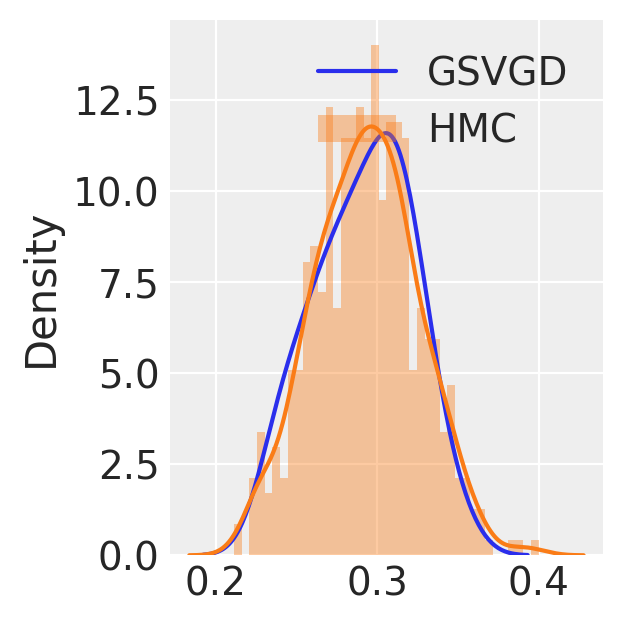

In [125]:
plt.figure(figsize=(3,3))
plot_histogram(x_gsvgd[:,5], label="GSVGD")
sns.distplot(mcmc_samples[-500:,5], hist=True, bins=40, label="HMC")
plt.legend()

In [141]:
hmc_cov = np.cov(np.concatenate([mcmc_samples[-50:],trace.get_values("sigma")[-50:,None]],axis=1))

In [142]:
gsvgd_cov = np.cov(x_gsvgd.detach().cpu().numpy())
maxsvgd_cov = np.cov(x_maxsvgd.detach().cpu().numpy())
svgd_cov = np.cov(x_svgd.detach().cpu().numpy())

In [150]:
print(f"GSVGD: {np.sqrt(np.sum((gsvgd_cov - hmc_cov) ** 2))}, Sliced: {np.sqrt(np.sum((maxsvgd_cov - hmc_cov) ** 2))}, SVGD: {np.sqrt(np.sum((svgd_cov - hmc_cov) ** 2))}")


GSVGD: 1.4513141637838314, Sliced: 1.5058466545712474, SVGD: 1.4626564203465138
